#### Hand Sign Recognition -> It is a MultiClass Classification hence we will be using the MLP as our model architecture

# Imports

In [1]:
from numpy.random import seed
seed(888)
from tensorflow.random import set_seed
set_seed(404)

In [2]:
import os
import numpy as np
import cv2

import tensorflow as tf

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.callbacks import TensorBoard

from time import strftime

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

# Constants

In [4]:
train_dir_digits = './Sign-Language-Digits-Dataset/Dataset/'
test_dir_digits = './Sign-Language-Digits-Dataset/Examples/'

classes = ['0','1','2','3','4','5','6','7','8','9']

IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_PIXELS = IMAGE_HEIGHT * IMAGE_WIDTH
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS
VALIDATION_SIZE=10000
VALIDATION_RATIO=0.2
LOGGING_PATH = 'tensorboard_hand-sign_digit_logs/'

NR_CLASSES = len(classes)

# A Look At The Data

## The Digits

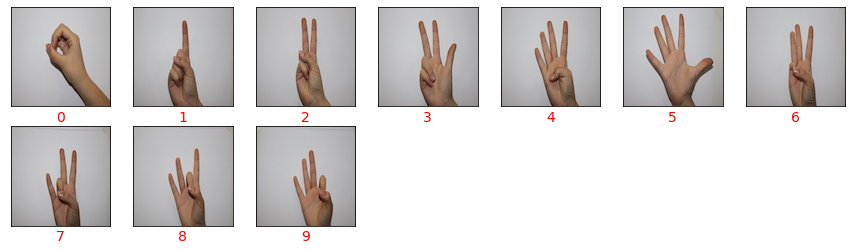

In [5]:
plt.figure(figsize=(15, 15))
for i in range (0,10):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    path = train_dir_digits + "{0}/".format(classes[i])
    data = os.listdir(path)
    path = path + data[0]
    img = plt.imread(path)
    plt.imshow(img)
    label = plt.xlabel(classes[i], fontsize=14)
    label.set_color("red")


# Get The Data

In [6]:
def load_data(train_dir):
    images = []
    labels = []
    size = IMAGE_HEIGHT,IMAGE_WIDTH
    for directory in os.listdir(train_dir):
        for image in os.listdir(train_dir + "/" + directory):
            img = cv2.imread(train_dir + '/' + directory + '/' + image)
            final_img = cv2.resize(img, size)
            images.append(final_img)
            idx = int(directory)
            labels.append(idx)
        print('loaded:', directory, 'label:', idx)
    images = np.array(images)
    labels = utils.to_categorical(labels)
    
    return images,labels

In [7]:
%%time

images,labels = load_data(train_dir_digits)

loaded: 0 label: 0
loaded: 1 label: 1
loaded: 2 label: 2
loaded: 3 label: 3
loaded: 4 label: 4
loaded: 5 label: 5
loaded: 6 label: 6
loaded: 7 label: 7
loaded: 8 label: 8
loaded: 9 label: 9
Wall time: 2.26 s


# Exlpore The Data

In [8]:
nr_images, x, y, c = images.shape
print(f'images = {nr_images} \t| width = {x} \t| height = {y} \t| channels = {c}')

images = 2062 	| width = 64 	| height = 64 	| channels = 3


# Data Preprocessing 

In [9]:
images = images.astype('float32')/255.0

In [10]:
images[0][0][0]

array([0.7058824, 0.7058824, 0.7058824], dtype=float32)

In [11]:
labels.shape

(2062, 10)

In [12]:
images.shape

(2062, 64, 64, 3)

In [13]:
labels[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [14]:
# images = images.reshape(images.shape[0], *(IMAGE_HEIGHT, IMAGE_WIDTH, 1))

In [15]:
images.shape

(2062, 64, 64, 3)

# Train Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1)

In [17]:
X_train.shape

(1855, 64, 64, 3)

In [18]:
# X_train = X_train[:, 1:]
# y_train = y_test[:, 0]
# X_test = X_test[:, 1:]
# y_test = y_test[:, 0]

In [19]:
X_test.shape

(207, 64, 64, 3)

In [20]:
y_test.shape

(207, 10)

In [21]:
# X_train = X_train.reshape(X_train[0].shape[0], IMAGE_HEIGHT,IMAGE_WIDTH,1)

# Create Validation Dataset

In [22]:
# X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.2, random_state = 1024)

In [23]:
# X_train.shape

In [24]:
# X_validate.shape

# Tensorflow Architecture Setup

#### Hyperparameters

In [25]:
nr_epochs = 25
learning_rate = 1e-3

#### Defining the model

In [26]:
mlp = Sequential()

mlp.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp.add(MaxPooling2D(pool_size = (2, 2)))

mlp.add(Conv2D(128 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp.add(MaxPooling2D(pool_size = (2, 2)))

mlp.add(Conv2D(256 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp.add(MaxPooling2D(pool_size = (2, 2)))

mlp.add(BatchNormalization())

mlp.add(Flatten())

mlp.add(Dropout(0.5))
mlp.add(Dense(1024, activation='sigmoid'))
mlp.add(Dense(NR_CLASSES, activation='softmax'))

In [27]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1

### model 2

In [44]:
mlp2 = Sequential()

mlp2.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2.add(MaxPooling2D(pool_size = (2, 2)))

mlp2.add(Conv2D(64 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2.add(MaxPooling2D(pool_size = (2, 2)))

mlp2.add(Conv2D(128 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))

mlp2.add(Conv2D(256 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2.add(MaxPooling2D(pool_size = (2, 2)))

mlp2.add(Conv2D(256 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2.add(MaxPooling2D(pool_size = (2, 2)))

mlp2.add(Conv2D(128 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2.add(MaxPooling2D(pool_size = (2, 2)))

mlp2.add(Conv2D(64 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2.add(MaxPooling2D(pool_size = (2, 2)))

mlp2.add(Dropout(0.25))

mlp2.add(Flatten())

mlp2.add(Dense(NR_CLASSES, activation='softmax'))

In [45]:
mlp2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 256)        

# Tensorboard Setup

In [30]:
def get_tensorboard(model_name):
    folder_name = f'{model_name} at {strftime("%H %M")}'
    dir_paths = os.path.join(LOGGING_PATH, folder_name)
    try:
        os.makedirs(dir_paths)
    except OSError as err:
        print(err.strerror)
    else:
        print('Successfully created directory')
    return TensorBoard(log_dir=dir_paths, histogram_freq=1)

# Train The Model

### Compile

In [31]:
adam = Adam(lr=learning_rate)

mlp.compile(loss ='categorical_crossentropy', optimizer=adam ,metrics =['accuracy'])

In [46]:
adam = Adam(lr=learning_rate)

mlp2.compile(loss ='categorical_crossentropy', optimizer=adam ,metrics =['accuracy'])

### Train

In [33]:
# history = mlp.fit(X_train, y_train, batch_size = 64, epochs = nr_epochs, verbose = 1,
#                   validation_data = (X_validate, y_validate), callbacks=[get_tensorboard('Model 1 MLP-VAL')])
history = mlp.fit(X_train, y_train, batch_size=64, epochs=nr_epochs, validation_split=0.1, shuffle = True, verbose=1,
                  callbacks=[get_tensorboard('Model 1 MLP-VAL')])

Successfully created directory
Epoch 1/25
27/27 [==============================] - 7s 108ms/step - loss: 3.0522 - accuracy: 0.3330 - val_loss: 2.0115 - val_accuracy: 0.3656
Epoch 2/25
27/27 [==============================] - 1s 26ms/step - loss: 0.6008 - accuracy: 0.7891 - val_loss: 1.8145 - val_accuracy: 0.6559
Epoch 3/25
27/27 [==============================] - 1s 26ms/step - loss: 0.4850 - accuracy: 0.8419 - val_loss: 1.6526 - val_accuracy: 0.5753
Epoch 4/25
27/27 [==============================] - 1s 26ms/step - loss: 0.2412 - accuracy: 0.9147 - val_loss: 1.3895 - val_accuracy: 0.6989
Epoch 5/25
27/27 [==============================] - 1s 26ms/step - loss: 0.1495 - accuracy: 0.9507 - val_loss: 1.1907 - val_accuracy: 0.7742
Epoch 6/25
27/27 [==============================] - 1s 26ms/step - loss: 0.1311 - accuracy: 0.9641 - val_loss: 1.0278 - val_accuracy: 0.7581
Epoch 7/25
27/27 [==============================] - 1s 26ms/step - loss: 0.0919 - accuracy: 0.9802 - val_loss: 0.8297 - va

In [34]:
X_train.shape

(1855, 64, 64, 3)

In [35]:
y_train.shape

(1855, 10)

In [47]:
history2 = mlp2.fit(X_train, y_train, batch_size=64, epochs=nr_epochs, validation_split=0.1, shuffle = True, verbose=1,
                  callbacks=[get_tensorboard('Model 2 MLP-VAL')])

Successfully created directory
Epoch 1/25
27/27 [==============================] - 3s 85ms/step - loss: 2.3130 - accuracy: 0.0951 - val_loss: 2.3032 - val_accuracy: 0.0914
Epoch 2/25
27/27 [==============================] - 1s 22ms/step - loss: 2.3026 - accuracy: 0.1021 - val_loss: 2.3033 - val_accuracy: 0.0968
Epoch 3/25
27/27 [==============================] - 1s 21ms/step - loss: 2.3022 - accuracy: 0.1009 - val_loss: 2.3036 - val_accuracy: 0.0968
Epoch 4/25
27/27 [==============================] - 1s 22ms/step - loss: 2.3026 - accuracy: 0.0963 - val_loss: 2.3015 - val_accuracy: 0.0968
Epoch 5/25
27/27 [==============================] - 1s 21ms/step - loss: 2.2681 - accuracy: 0.1414 - val_loss: 2.4690 - val_accuracy: 0.1774
Epoch 6/25
27/27 [==============================] - 1s 23ms/step - loss: 1.7256 - accuracy: 0.4063 - val_loss: 1.1439 - val_accuracy: 0.6075
Epoch 7/25
27/27 [==============================] - 1s 21ms/step - loss: 1.0101 - accuracy: 0.6484 - val_loss: 0.6679 - val

In [37]:
# %load_ext tensorboard

In [38]:
# dir_paths = os.path.join(LOGGING_PATH, 'Model 1 MLP-VAL at 23 38')
# %tensorboard --logdir LOGGING_PATH

# Visualizing Accuracy

Text(0.5, 1.0, 'Accuracy evolution')

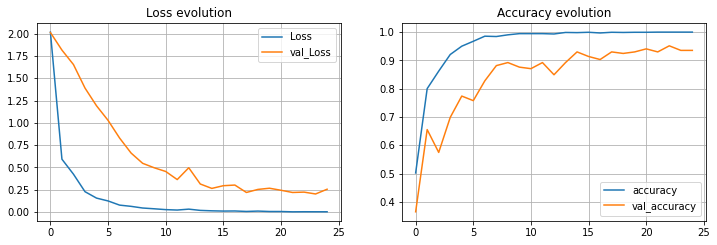

In [48]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

# Model 2

Text(0.5, 1.0, 'Accuracy evolution')

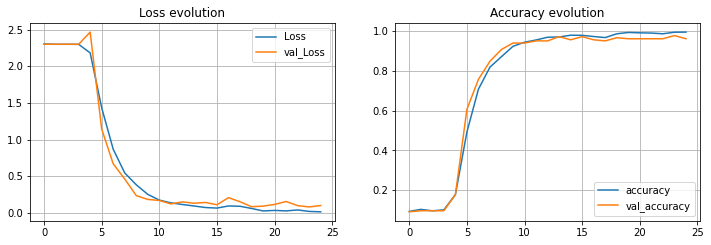

In [49]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history2.history['loss'], label='Loss')
plt.plot(history2.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')